# Import Libraries

In [1]:
import pandas as pd
import re
from tqdm import tqdm
!pip install indic-nlp-library --q
from indicnlp.tokenize.indic_tokenize import trivial_tokenize
from indicnlp.tokenize.sentence_tokenize import sentence_split
import os
# cwd=os.getcwd()
# os.chdir('/kaggle/input/telugu-tokenizer/')
from TeluguTokenizer.tokenizer import *
# os.chdir(cwd)

In [2]:
dataset_path='../../Dataset/'
train_fp=dataset_path+'TeClass_training_data.csv'
dev_fp=dataset_path+'TeClass_development_data.csv'
test_fp=dataset_path+'TeClass_testing_data.csv'

In [3]:
def read_csv(fp):
    df=pd.read_csv(fp)
    return df

In [4]:
train_df=read_csv(train_fp)
dev_df=read_csv(dev_fp)
test_df=read_csv(test_fp)

In [5]:
train_df.head(1)

,id,url,article,headline,label
0,training_1,https://www.manatelangana.news/one-person-watc...,హైదరాబాద్ : “రాజు గారి గది” సినిమా చూస్తూ ఓ ప్...,వ్యక్తి ప్రాణాలు తీసిన “రాజు గారి గది” సినిమా,MREL


# Extracting features

### Abstractivity (Novel N-Gram percentage)

In [6]:
### Compute the set of Extractive Fragments F(A, S) (the set of shared sequences of tokens in A and S)
def F(A, S, ng = 0):
    '''
        This method is responsible to compute the set of extractive fragments given the article and summary (Headline)

        Input:
            @A -> Article text
            @S -> Summary text (Headline)
            @ng -> abstractivity type [0, 1, 2, 3]
        Output:
            Set of matched sequences.
    '''
    F = []
    i = j = 0
    i_hat = 0

    while i<len(S):

        f = []
        while j<len(A):

            if S[i]==A[j]:

                i_hat = i
                j_hat = j

                while i_hat<len(S) and j_hat<len(A) and S[i_hat] == A[j_hat]:
                    i_hat = i_hat + 1
                    j_hat = j_hat + 1

                if (i_hat-i) > ng and len(f)<(i_hat - i):
                    f = [S[n] for n in range(i, i_hat)]

                j = j_hat

            else:
                j = j + 1

        i = i + max(len(f),1)
        j = 0
        F.append(f)
    
    return set(tuple(e) for e in F)

In [7]:
### Compare abstractivity score
def get_abstractivity_score(article_content, summary_content, ng=0):
    '''
        This method is responsible to compute the abstractivity score using the Extractive Fragments F(A, S)

        Input:
            @article_content -> article text
            @summary_content -> summary text (headline)
        Output:
            @abstractivity -> abstractivity0 score
    '''
    
    ### Preprocess the article and summary with preprocess_data
    summary_content = preprocess_data(summary_content)
    article_content = preprocess_data(article_content)

    ### Tokenization of article and summary with sentence tokenize
    summary_sents = sentence_split(summary_content,lang='te')
    article_sents = sentence_split(article_content,lang='te')

    ### Tokenization of article and summary with word tokenize
    summary_tokens_with_punct = word_tokenize(summary_sents)
    article_tokens_with_punct = word_tokenize(article_sents)

    ### Remove the punctuations from the tokens list and within the tokens
    summary_tokens = remove_punctuation(summary_tokens_with_punct)
    article_tokens = remove_punctuation(article_tokens_with_punct)
    

    # Calculating Abstractivity-0 score for article-summary pair
    abstractivity = -1
    matched_fragments = F(article_tokens, summary_tokens, ng)
    # print(matched_fragments)
    sumF_abs = 0
    for f in matched_fragments:
        sumF_abs += len(f)
    total_stokens = len(summary_tokens)
    if(total_stokens>0):
        abstractivity = (round((100 - (sumF_abs/total_stokens)*100), 2))
    
    return abstractivity

In [8]:
def extract_features(df):
    ng_values=[0,1]
    n_punctuations=[]
    n_specialsymbols=[]
    for ng in ng_values:
        temp=[]
        for i in tqdm(range(len(df))):
            a=df['article'].iloc[i]
            h=df['headline'].iloc[i]
            abst=get_abstractivity_score(a,h,ng)
            temp.append(abst)

        column_name='Novel_'+str(ng+1)+'_gram_percentage'
        df[column_name]=temp
        
    return df

In [9]:
train_df=extract_features(train_df)

100%|██████████| 18324/18324 [00:23<00:00, 780.33it/s]


In [10]:
dev_df=extract_features(dev_df)

100%|██████████| 3927/3927 [00:05<00:00, 764.01it/s]


In [11]:
test_df=extract_features(test_df)

100%|██████████| 3927/3927 [00:05<00:00, 761.42it/s]


In [12]:
dev_df.head(1)

,id,url,article,headline,label,Novel_1_gram_percentage,Novel_2_gram_percentage
0,development_1,https://10tv.in/movies/high-court-key-comments...,తెలుగు బుల్లితెరపై సంచలనం .. బిగ్ బాస్ .. ఈ షో...,బిగ్ బాస్ 3 షో పై హైకోర్టు కీలక వ్యాఖ్యలు,LREL,25.0,37.5


### Lead-1 and Extractive Oracle Score

In [13]:
!pip install absl-py nltk numpy six>=1.14 pythainlp pyonmttok jieba fugashi[unidic]
os.chdir('../multilingual rouge/')
from rouge_score import rouge_scorer
os.chdir(cwd)
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=False, lang='te')

In [14]:
def return_rouge_score(ref,hyp):
    scores = scorer.score(ref, hyp) # ref and hyp must be in string format only
    r1_f=scores['rouge1'][2] # index 2 corresponds to f-1 score, 0-precsion,1-recall
    r2_f=scores['rouge2'][2]
    rL_f=scores['rougeL'][2]
    return r1_f,r2_f,rL_f

In [15]:
### Compute Lead-1 and EXT-ORACLE R-L score
def get_lead1_ext_score(df):
    lead1_scores_rL=[]
    ext_scores_rL=[]
    for i in tqdm(range(len(df))):
        article_content=df['article'].iloc[i]
        summary_content=df['headline'].iloc[i]
        ### Preprocess the article and summary with preprocess_data
        summary_content = preprocess_data(summary_content)
        article_content = preprocess_data(article_content)

        ### Tokenization of article and summary with sentence tokenize
        summary_sents = sentence_split(summary_content,lang='te')
        article_sents = sentence_split(article_content,lang='te')
        
        def ext_oracle_score():
            ref = summary_content
            max_rL_sent_index=0
            rL_max=0
            for idx,sent in enumerate(article_sents):
                hyp = sent
                r1,r2,rL = return_rouge_score(ref,hyp)
                if rL>rL_max:
                    rL_max=rL
                    max_rL_sent_index=idx
            # take max R-L sent as hyp
            try:
                hyp=article_sents[max_rL_sent_index]
            except:
                hyp=''
            r1,r2,rL = return_rouge_score(ref,hyp)
            ext_scores_rL.append(rL*100)
        ext_oracle_score()
        
        def lead_1_score():
            ref = summary_content
            try:
                hyp = article_sents[0]
            except:
                hyp = ''
                
            r1,r2,rL = return_rouge_score(ref,hyp)
            lead1_scores_rL.append(rL*100)
        lead_1_score()
    
    df['Lead-1 Score']=lead1_scores_rL
    df['EXT-ORACLE Score']=ext_scores_rL
    return df

In [16]:
train_df=get_lead1_ext_score(train_df)

100%|██████████| 18324/18324 [03:00<00:00, 101.46it/s]


In [17]:
dev_df=get_lead1_ext_score(dev_df)

100%|██████████| 3927/3927 [00:38<00:00, 101.80it/s]


In [18]:
test_df=get_lead1_ext_score(test_df)

100%|██████████| 3927/3927 [00:38<00:00, 102.46it/s]


In [19]:
train_df.head(1)

,id,url,article,headline,label,Novel_1_gram_percentage,Novel_2_gram_percentage,Lead-1 Score,EXT-ORACLE Score
0,training_1,https://www.manatelangana.news/one-person-watc...,హైదరాబాద్ : “రాజు గారి గది” సినిమా చూస్తూ ఓ ప్...,వ్యక్తి ప్రాణాలు తీసిన “రాజు గారి గది” సినిమా,MREL,42.86,42.86,50.0,50.0


### TF-IDF Representation

In [20]:
# Using sub-word tokenization (BertTokenizer) to overcome the problem of out-of-vocabulary words
from transformers import BertTokenizer
# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")

# Define a custom tokenizer function that uses BERT tokenizer
def custom_tokenizer(text):
    # Tokenize the text using BERT tokenizer
    tokens = tokenizer.tokenize(text)
    return tokens

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

In [21]:
articles_list=list(train_df['article'].values)
titles_list=list(train_df['headline'].values)
corpus=articles_list+titles_list

from sklearn.feature_extraction.text import TfidfVectorizer
# Create a TfidfVectorizer instance with your custom tokenizer
tfidf_vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer)

In [22]:
# Fit the corpus
tf_idf_matrix = tfidf_vectorizer.fit(corpus)

/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [23]:
# # Get feature names (words in the vocabulary)
feature_names = tf_idf_matrix.get_feature_names_out()
print("Vocabulary size:",len(feature_names))

Vocabulary size: 2945


In [24]:
# represent article, headline into vectors using TF-IDF
train_article_emb=tf_idf_matrix.transform(list(train_df['article'].values)).toarray()
train_title_emb=tf_idf_matrix.transform(list(train_df['headline'].values)).toarray()

dev_article_emb=tf_idf_matrix.transform(list(dev_df['article'].values)).toarray()
dev_title_emb=tf_idf_matrix.transform(list(dev_df['headline'].values)).toarray()

test_article_emb=tf_idf_matrix.transform(list(test_df['article'].values)).toarray()
test_title_emb=tf_idf_matrix.transform(list(test_df['headline'].values)).toarray()

### Cosine Similirity between Article and Headline vector representations

In [25]:
import numpy as np
from numpy import dot
from numpy.linalg import norm
def cosine_sim(a,b):
    cos_sim = dot(a, b)/(norm(a)*norm(b))
    #return np.array([cos_sim])
    return cos_sim

In [26]:
def get_cosine_sim(article_emb, headline_emb):
    cos_sim=[]
    for i in tqdm(range(len(article_emb))):
        a=article_emb[i]
        b=headline_emb[i]
        cos_sim.append(cosine_sim(a,b))
        
    return cos_sim

In [27]:
train_cos_sim=get_cosine_sim(train_article_emb,train_title_emb)
dev_cos_sim=get_cosine_sim(dev_article_emb,dev_title_emb)
test_cos_sim=get_cosine_sim(test_article_emb,test_title_emb)

100%|██████████| 3927/3927 [00:00<00:00, 34996.13it/s]


In [28]:
train_df['Cosine_Similarity']=train_cos_sim
dev_df['Cosine_Similarity']=dev_cos_sim
test_df['Cosine_Similarity']=test_cos_sim

In [29]:
train_df.head(1)

,id,url,article,headline,label,Novel_1_gram_percentage,Novel_2_gram_percentage,Lead-1 Score,EXT-ORACLE Score,Cosine_Similarity
0,training_1,https://www.manatelangana.news/one-person-watc...,హైదరాబాద్ : “రాజు గారి గది” సినిమా చూస్తూ ఓ ప్...,వ్యక్తి ప్రాణాలు తీసిన “రాజు గారి గది” సినిమా,MREL,42.86,42.86,50.0,50.0,0.317002


# Baseline Models Implementation

### Get Required Features to concat with TF-IDF encoding

In [30]:
include_features=True
req_features=['Cosine_Similarity','Novel_1_gram_percentage','Novel_2_gram_percentage','Lead-1 Score','EXT-ORACLE Score']

In [31]:
def return_features(data):
    features=[]
    for i in range(len(data)):
        temp=[]
        for feature in req_features:
            if feature!='Cosine_Similarity':
                temp.append(data[feature].iloc[i]/100) # since the features values are in the range 0-100, scaling them to 0-1
            else:
                temp.append(data[feature].iloc[i])
        features.append(np.array(temp))
    return features

In [32]:
train_features=return_features(train_df)
dev_features=return_features(dev_df)
test_features=return_features(test_df)

### Concat Required Features with TF-IDF encoding

In [33]:
if include_features:
    print('Using Features: ',req_features)
    X_train=np.concatenate((train_article_emb,train_features,train_title_emb),axis=1)
    X_dev=np.concatenate((dev_article_emb,dev_features,dev_title_emb),axis=1)
    X_test=np.concatenate((test_article_emb,test_features,test_title_emb),axis=1)
    #print(X_train.shape)
else:
    print('Concatenating Article and Headline Embedding (No additional features)')
    X_train=np.concatenate((train_article_emb,train_title_emb),axis=1)
    X_dev=np.concatenate((dev_article_emb,dev_title_emb),axis=1)
    X_test=np.concatenate((test_article_emb,test_title_emb),axis=1)

Using Features:  ['Cosine_Similarity', 'Novel_1_gram_percentage', 'Novel_2_gram_percentage', 'Lead-1 Score', 'EXT-ORACLE Score']


In [34]:
print("Train Shape:{}, Dev Shape:{}, Test Shape:{}".format(X_train.shape,X_dev.shape,X_test.shape))

Train Shape:(18324, 5895), Dev Shape:(3927, 5895), Test Shape:(3927, 5895)


### Converting Output Labels to Categorical

In [35]:
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

# Convert the labels in train_df
train_labels = train_df['label'].values
train_labels_encoded = label_encoder.fit_transform(train_labels)

# Convert the labels in val_df
dev_labels = dev_df['label'].values
dev_labels_encoded = label_encoder.transform(dev_labels)

# Convert the labels in test_df
test_labels = test_df['label'].values
test_labels_encoded = label_encoder.transform(test_labels)

# Convert the encoded labels to one-hot vectors
y_train_encoded = tf.keras.utils.to_categorical(train_labels_encoded)
y_dev_encoded = tf.keras.utils.to_categorical(dev_labels_encoded)
y_test_encoded = tf.keras.utils.to_categorical(test_labels_encoded)

2024-04-09 08:51:56.862070: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-09 08:51:56.862225: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-09 08:51:57.040174: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [36]:
encoded_classes = label_encoder.classes_
print(encoded_classes)

['HREL' 'LREL' 'MREL']


In [37]:
n_classes=len(encoded_classes)

In [38]:
id_to_label={}
label_to_id={}
for i,v in enumerate(encoded_classes):
    id_to_label[i]=v
    label_to_id[v]=1

### Model Name: Multi Layer Perceptron (MLP)

In [39]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Define hyperparameters
num_classes = n_classes  # Change this to your desired number of classes
input_size =  X_train.shape[1]  # Set this to the dimension of your TF-IDF embeddings
hidden_size = 64  # You can adjust this as needed
batch_size = 32
learning_rate = 0.001
num_epochs = 10

# Early stopping parameters
patience = 3  # Number of epochs with no improvement to wait before stopping
best_dev_accuracy = 0.0
counter = 0

# Load your TF-IDF embeddings and labels
train_embeddings = X_train
dev_embeddings = X_dev
test_embeddings =X_test
train_labels = train_labels_encoded
dev_labels = dev_labels_encoded
test_labels = test_labels_encoded

# Convert data to PyTorch tensors
train_data = TensorDataset(torch.tensor(train_embeddings, dtype=torch.float32),
                           torch.tensor(train_labels, dtype=torch.long))
dev_data = TensorDataset(torch.tensor(dev_embeddings, dtype=torch.float32),
                         torch.tensor(dev_labels, dtype=torch.long))
test_data = TensorDataset(torch.tensor(test_embeddings, dtype=torch.float32),
                          torch.tensor(test_labels, dtype=torch.long))

# Create data loaders
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
dev_loader = DataLoader(dev_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

In [40]:
# Define the neural network model
class MultilayerNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MultilayerNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [41]:
# Initialize the model and optimizer
model = MultilayerNN(input_size, hidden_size, num_classes)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [42]:
# Training loop
for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
    # Evaluate on the development set
    model.eval()
    with torch.no_grad():
        dev_predictions=[]
        correct = 0
        total = 0
        for inputs, labels in dev_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            dev_predictions.extend(list(predicted.numpy()))
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        accuracy = 100 * correct / total
        print(f'Epoch [{epoch + 1}/{num_epochs}] | Dev Accuracy: {accuracy:.2f}%')
        
        # Check for early stopping
        if accuracy > best_dev_accuracy:
            best_dev_accuracy = accuracy
            counter = 0
        else:
            counter += 1
        
        if counter >= patience:
            print(f'Early stopping after {epoch + 1} epochs.')
            break

Epoch [1/10] | Dev Accuracy: 56.20%
Epoch [2/10] | Dev Accuracy: 57.80%
Epoch [3/10] | Dev Accuracy: 57.78%
Epoch [4/10] | Dev Accuracy: 56.94%
Epoch [5/10] | Dev Accuracy: 56.61%
Early stopping after 5 epochs.


In [43]:
# Evaluate on the test set
model.eval()
with torch.no_grad():
    test_predictions=[]
    correct = 0
    total = 0
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        test_predictions.extend(list(predicted.numpy()))
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    test_accuracy = 100 * correct / total
    print(f'Test Accuracy: {test_accuracy:.2f}%')

# Save the trained model if needed
torch.save(model.state_dict(), 'multilayer_nn_model.pth')

Test Accuracy: 56.23%


In [44]:
mlp_test_predictions=label_encoder.inverse_transform(test_predictions)

### Model Name: Logistic Regression

In [45]:
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Combine the training and dev sets
X_train_dev = np.concatenate((X_train, X_dev), axis=0)
y_train_dev = np.concatenate((train_labels,dev_labels), axis=0)

# Initialize a logistic regression model
model = LogisticRegression(multi_class='ovr', solver='liblinear')

# Perform K-Fold cross-validation on the combined training and dev set
num_folds = 5  # Change this to the desired number of folds
cv_scores = cross_val_score(model, X_train_dev, y_train_dev, cv=num_folds, scoring='accuracy')

# Print the cross-validation scores for each fold
print("Cross-validation scores:", cv_scores)

# Calculate the average cross-validation score
avg_cv_score = cv_scores.mean()
print("Average Cross-validation score:", avg_cv_score)

# Train the model on the entire combined training and dev set
model.fit(X_train_dev, y_train_dev)

# Evaluate the model on the test set
lr_test_predictions = model.predict(X_test)
test_accuracy = accuracy_score(test_labels, lr_test_predictions)
print(f'Test Accuracy: {test_accuracy:.2f}')

Cross-validation scores: [0.55942485 0.56269663 0.56629213 0.56404494 0.57595506]
Average Cross-validation score: 0.5656827224787259
Test Accuracy: 0.58


In [46]:
lr_test_predictions=label_encoder.inverse_transform(lr_test_predictions)

### Model Name: Support Vector Machine

In [47]:
from sklearn import svm
# Combine the training and dev sets
X_train_dev = np.concatenate((X_train, X_dev), axis=0)
y_train_dev = np.concatenate((train_labels,dev_labels), axis=0)

# Initialize a logistic regression model
clf = svm.LinearSVC()
model = clf

# Perform K-Fold cross-validation on the combined training and dev set
num_folds = 5  # Change this to the desired number of folds
cv_scores = cross_val_score(model, X_train_dev, y_train_dev, cv=num_folds, scoring='accuracy')

# Print the cross-validation scores for each fold
print("Cross-validation scores:", cv_scores)

# Calculate the average cross-validation score
avg_cv_score = cv_scores.mean()
print("Average Cross-validation score:", avg_cv_score)

# Train the model on the entire combined training and dev set
model.fit(X_train_dev, y_train_dev)

# Evaluate the model on the test set
svm_test_pred = model.predict(X_test)
test_accuracy = accuracy_score(test_labels, svm_test_pred)
print(f'Test Accuracy: {test_accuracy:.2f}')

Cross-validation scores: [0.54032802 0.55033708 0.55011236 0.54       0.55662921]
Average Cross-validation score: 0.5474813335723067
Test Accuracy: 0.57


In [48]:
svm_test_predictions=label_encoder.inverse_transform(svm_test_pred)

### Model Name: Bagging

In [49]:
from sklearn import svm
from sklearn.ensemble import BaggingClassifier
# Combine the training and dev sets
X_train_dev = np.concatenate((X_train, X_dev), axis=0)
y_train_dev = np.concatenate((train_labels,dev_labels), axis=0)

# Initialize a logistic regression model
clf = svm.LinearSVC()
model = BaggingClassifier(clf)

# Perform K-Fold cross-validation on the combined training and dev set
num_folds = 5  # Change this to the desired number of folds
cv_scores = cross_val_score(model, X_train_dev, y_train_dev, cv=num_folds, scoring='accuracy')

# Print the cross-validation scores for each fold
print("Cross-validation scores:", cv_scores)

# Calculate the average cross-validation score
avg_cv_score = cv_scores.mean()
print("Average Cross-validation score:", avg_cv_score)

# Train the model on the entire combined training and dev set
model.fit(X_train_dev, y_train_dev)

# Evaluate the model on the test set
bagging_test_pred = model.predict(X_test)
test_accuracy = accuracy_score(test_labels, bagging_test_pred)
print(f'Test Accuracy: {test_accuracy:.2f}')

Cross-validation scores: [0.54032802 0.54022472 0.54898876 0.53955056 0.5552809 ]
Average Cross-validation score: 0.544874591999273
Test Accuracy: 0.56


In [50]:
bagging_test_predictions=label_encoder.inverse_transform(bagging_test_pred)

### Classification Report and Confusion Matrix

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
def plot_cm(y_true, y_pred):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Define class labels
    # classes = np.unique(y_true) 
    classes = ["HREL", "MREL", "LREL"] # to print the matrix labels in order (other wise comment this and uncomment above line)

    # Plot confusion matrix
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=classes, yticklabels=classes)

    # Add labels, title, and axis ticks
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

In [52]:
from sklearn.metrics import classification_report
def print_classification_report(y_true, y_pred):
    # Define class labels
    #classes = np.unique(y_true)
    classes = ["HREL", "MREL", "LREL"] # to print the matrix labels in order (other wise comment this and uncomment above line)
    print(classification_report(y_true=y_true, y_pred=y_pred,target_names=classes,zero_division=0))

In [53]:
def display_result(model_name, test_predictions):
    print('Model Name:{}\n'.format(model_name))
    # Example ground truth labels and predicted labels
    y_true = np.array(label_encoder.inverse_transform(test_labels))
    y_pred = np.array(test_predictions)
    plot_cm(y_true, y_pred)
    print_classification_report(y_true, y_pred)

Model Name:Multilayer Perceptron



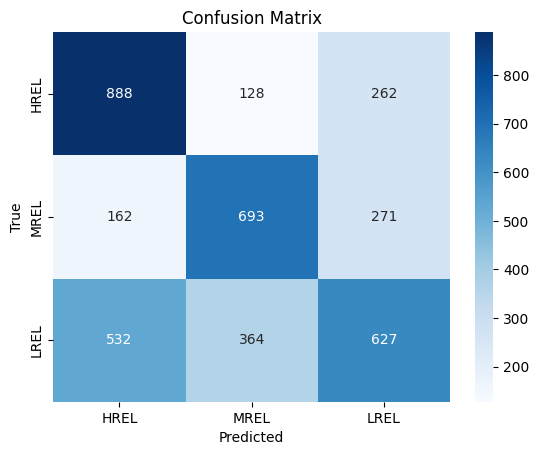

              precision    recall  f1-score   support

        HREL       0.56      0.69      0.62      1278
        MREL       0.58      0.62      0.60      1126
        LREL       0.54      0.41      0.47      1523

    accuracy                           0.56      3927
   macro avg       0.56      0.57      0.56      3927
weighted avg       0.56      0.56      0.56      3927



In [54]:
display_result('Multilayer Perceptron',mlp_test_predictions)

Model Name:Logistic Regression



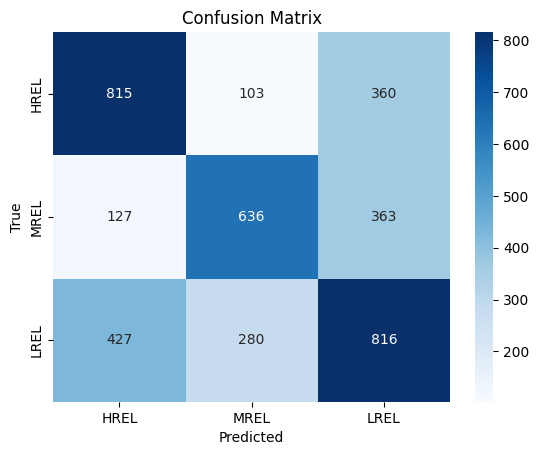

              precision    recall  f1-score   support

        HREL       0.60      0.64      0.62      1278
        MREL       0.62      0.56      0.59      1126
        LREL       0.53      0.54      0.53      1523

    accuracy                           0.58      3927
   macro avg       0.58      0.58      0.58      3927
weighted avg       0.58      0.58      0.58      3927



In [55]:
display_result('Logistic Regression',lr_test_predictions)

Model Name:Support Vector Machine



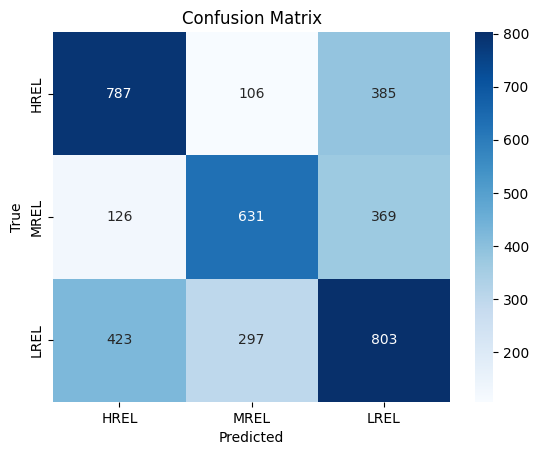

              precision    recall  f1-score   support

        HREL       0.59      0.62      0.60      1278
        MREL       0.61      0.56      0.58      1126
        LREL       0.52      0.53      0.52      1523

    accuracy                           0.57      3927
   macro avg       0.57      0.57      0.57      3927
weighted avg       0.57      0.57      0.57      3927



In [56]:
display_result('Support Vector Machine',svm_test_predictions)

Model Name:Bagging



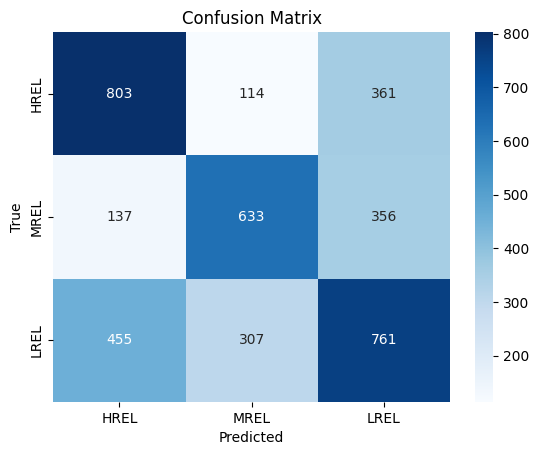

              precision    recall  f1-score   support

        HREL       0.58      0.63      0.60      1278
        MREL       0.60      0.56      0.58      1126
        LREL       0.51      0.50      0.51      1523

    accuracy                           0.56      3927
   macro avg       0.56      0.56      0.56      3927
weighted avg       0.56      0.56      0.56      3927



In [57]:
display_result('Bagging',bagging_test_predictions)